In [2]:
 import sys
! whoami
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)
_alphaadvantage = 'KW2PCDA3R4PR0QWO'  # alphadvantage API key KW2PCDA3R4PR0QWO
_quantl = 'cBtBbexR-ZQtNfbx_fyk'  # quandl API key = cBtBbexR-ZQtNfbx_fyk

compthink
/opt/conda/envs/python/bin/python
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


# What is a Time-Series?

Time Series comprises of observations that are captured at regular intervals. 
Time Series datasets have a strong temporal dependence (called serial correlation). 
It can be used to forecast future observations based on previous ones.

In this example, we will be using the stock prices of a certain company. However, do not trade based on this forecast, remember the example is presented by a University associate professor, who are idiots when it comes to making money. Stock prices are dependent on various factors like supply and demand, company performance, the sentiment of the investors, here it is an example of temporally correlated data, later on we will examine other such data with hydrologic significance, and get into issues of causality for prediction making.

## Decomposing the Time Series:

The Time-Series can be divided into several parts as follows:

* Trend: The increase or decrease in the value of the data. This can further be divided into the global trend and local trend. 

* Seasonality: It is the repetitive pattern that is visible in the series. This rise or fall in the values of the data is of fixed frequency. For example, the sales of Christmas trees are always greater during December and less for the rest. The tools of harmonic analysis are useful for this component.

* Cyclicity: It is the rise and fall in the value of the data which is not of a fixed frequency. It can be seen as an outcome of economic conditions or other external factors - this component is the `aperiodic` part of the signal, in many cases quite subtle.

* Noise: It is just some random data that we obtain after extracting the trend and the seasonal components from the time series. 

The components of the time series can be an additive or multiplicative version. 

![](TSplots.png)

<strong>An additive model is:</strong>

\begin{equation}
TS = Trend_t + Seasonality_t + Cyclicity_t + Noise_t
\end{equation}

The additive model is preferred when the magnitude of the seasonal pattern does not correlate with the data values.

<strong>A multiplicative (power-law) model is:</strong>

\begin{equation}
TS = Trend_t * Seasonality_t * Cyclicity_t * Noise_t
\end{equation}

The multiplicative model is preferred when the magnitude of the seasonal pattern increases or decreases with the increase or decrease in the data values. 

In the additive version, the magnitude of the seasonal pattern remains to be uncorrelated with the rising trend whereas it is increasing with the increase in the trend of the time series in the multiplicative version.

As with all our data science examples, we start with how to get a dataset

## How to obtain stock price data?

We can obtain stock prices by creating an API (Application Programming Interface) request using the `requests` package. We can also use the `quandl` package which is designed to provide financial and economic data.

We will extract the prices of US stocks from alphavantage website by creating an API call. Using the code fragment below, we have extracted the daily stock prices of IBM.

### Getting API keys
API keys are passkeys to the remote data sets.  In this example I already have keys that I obtained from the data vendor, they are free, but will be used to send future RFMs for goods and services.

So first we attach support packages

In [3]:
# attach support packages
import requests
import pandas as pd
import quandl
import numpy as np
from statsmodels.tsa.seasonal  import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Then the data requests

In [4]:
# Creating an API request to get the data for a stock.
req = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=_alphaadvantage&datatype=csv')
# Transforming the content of the request to a dataframe.
request_content = req.content
data = list(map(lambda x: x.split(','),request_content.decode('utf-8').split("\r\n")))
dataframe = pd.DataFrame(data[1:], columns=data[0])
dataframe = dataframe.set_index('timestamp')
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2020-07-23,129.1000,129.3700,127.1500,127.3300,127.3300,4160885,0.0000,1.0000
2020-07-22,125.9000,129.4700,125.8000,128.6700,128.6700,8195366,0.0000,1.0000
2020-07-21,131.1600,132.1700,125.8000,126.0600,126.0600,15356679,0.0000,1.0000
2020-07-20,126.0700,127.0700,125.1400,126.3700,126.3700,9737157,0.0000,1.0000
2020-07-17,124.3900,125.6300,123.2000,125.1100,125.1100,3984000,0.0000,1.0000


For using `quandl` package to import data into python, you need to install `quandl` package. I entered the command `! sudo -H /opt/conda/envs/python/bin/python -m pip install quandl` into the JupyterHub service notebook so it should be good to go. We have imported the prices of Infosys (BOM500209) and will use these for our further analysis. More documentation on `quandl` and how to get the best out of it can be found at the vendor website.

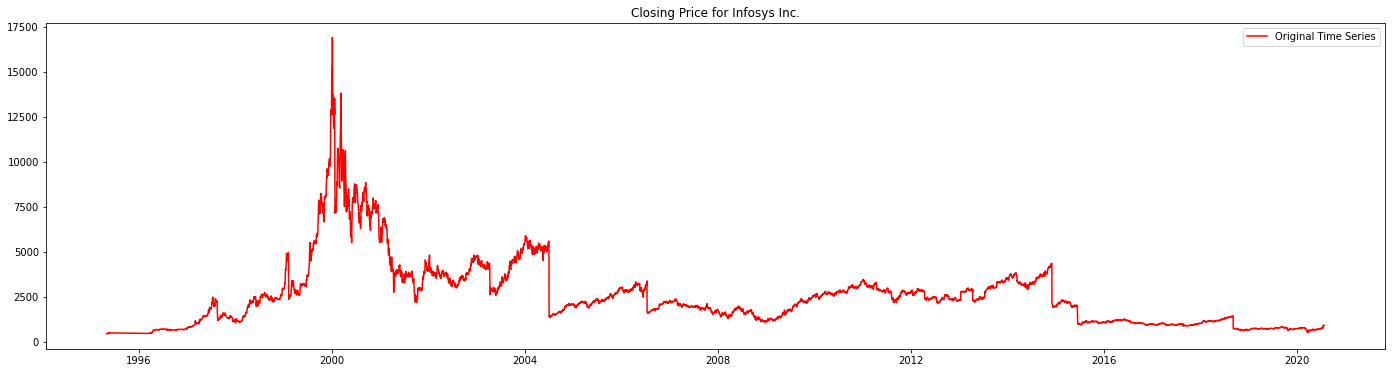

In [6]:
# Using quandl package to obtain data regarding a stock.
Stock_data = quandl.get("BSE/BOM500209",api_key="cBtBbexR-ZQtNfbx_fyk")
# Stock_data.info()
# Plot the Closing Price
plt.figure(figsize=(24,6))
plt.title('Closing Price for Infosys Inc.')
plt.plot(Stock_data['Close'], color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()

In [7]:
# Decomposition of trend, seasonality and residue of the original time series using seasonal decomposition tools
result = seasonal_decompose(Stock_data['Close'], model='multiplicative',period=30)
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.resid.describe()

count    6019.000000
mean        0.998432
std         0.060188
min         0.431963
25%         0.977452
50%         0.999661
75%         1.020287
max         1.618074
Name: resid, dtype: float64

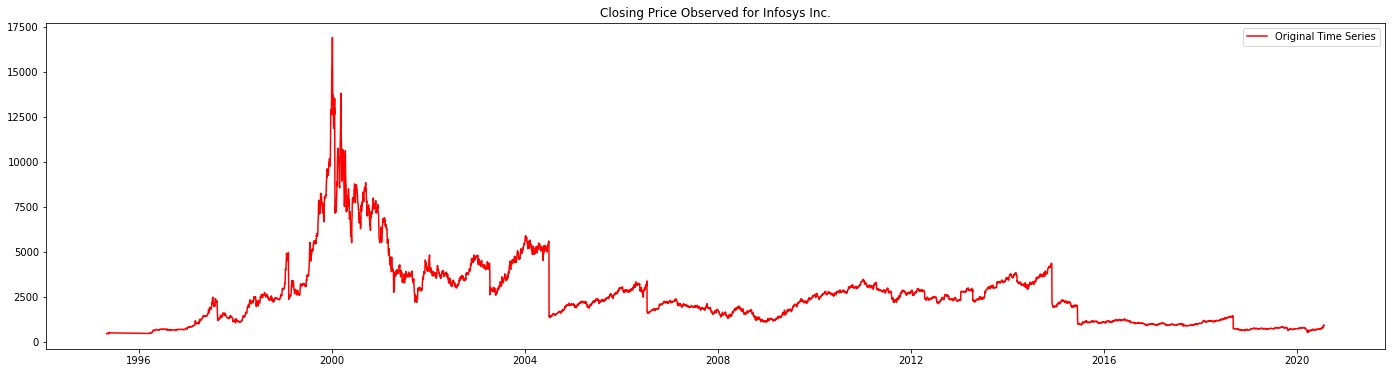

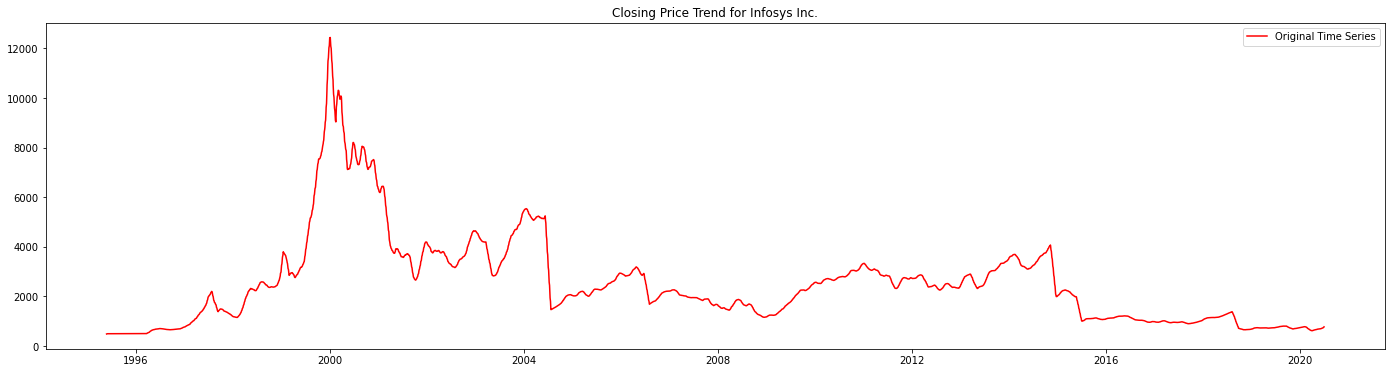

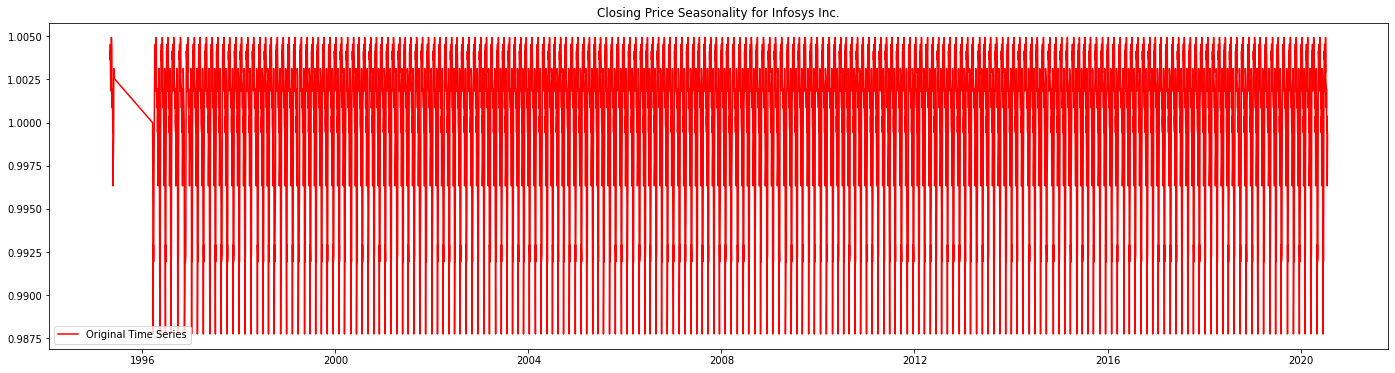

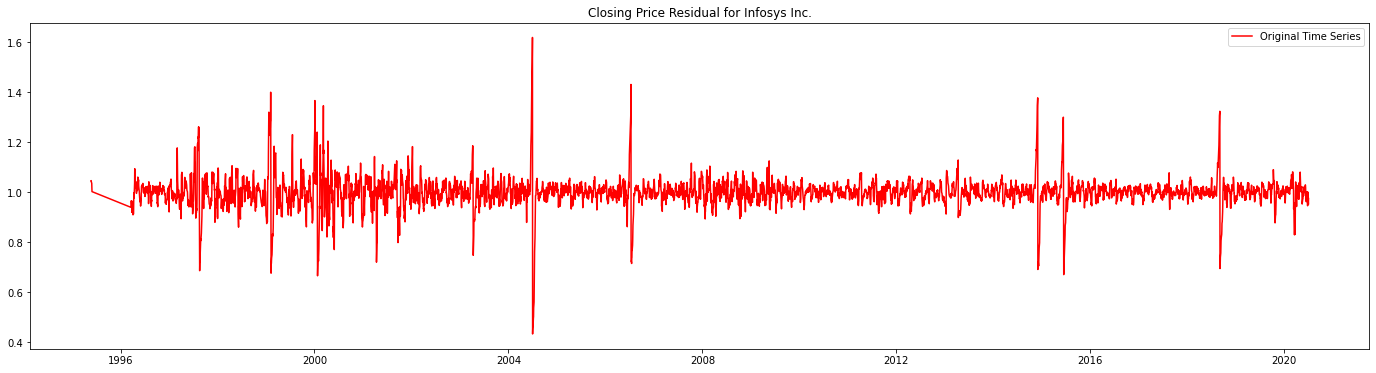

In [8]:
# Plot the Closing Price
plt.figure(figsize=(24,6))
plt.title('Closing Price Observed for Infosys Inc.')
plt.plot(result.observed, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()
# Plot the Closing Price Trend
plt.figure(figsize=(24,6))
plt.title('Closing Price Trend for Infosys Inc.')
plt.plot(result.trend, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()
# Plot the Closing Price Seasonality
plt.figure(figsize=(24,6))
plt.title('Closing Price Seasonality for Infosys Inc.')
plt.plot(result.seasonal, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()
# Plot the Closing Price Residual
plt.figure(figsize=(24,6))
plt.title('Closing Price Residual for Infosys Inc.')
plt.plot(result.resid, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()

The trend experiences some ups and downs as a stock generally does. It does not have a meaningful seasonal component. The residuals’ variance seems to remain the same except for a few observations.

If we repeat using an additive model, we obtain:

In [9]:
# Decomposition of trend, seasonality and residue of the original time series using seasonal decomposition tools
result = seasonal_decompose(Stock_data['Close'], model='additive',period=30)
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.resid.describe()

count    6019.000000
mean       -0.016174
std       261.421334
min     -3573.768184
25%       -46.704659
50%        -1.848815
75%        45.638016
max      4534.650247
Name: resid, dtype: float64

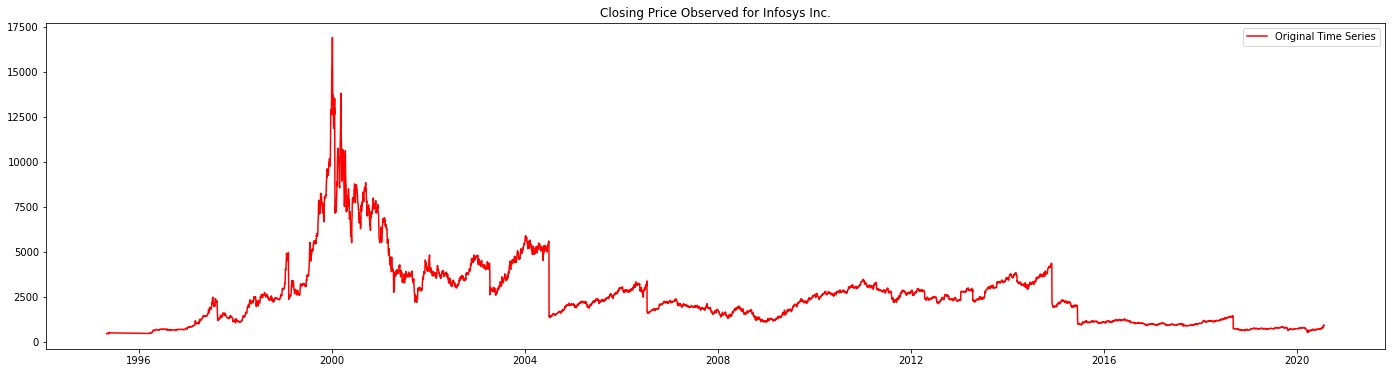

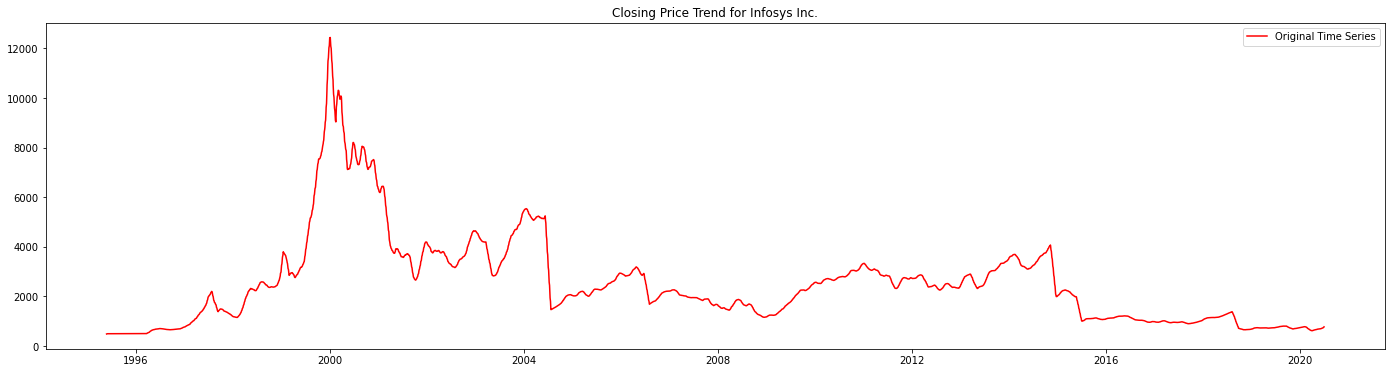

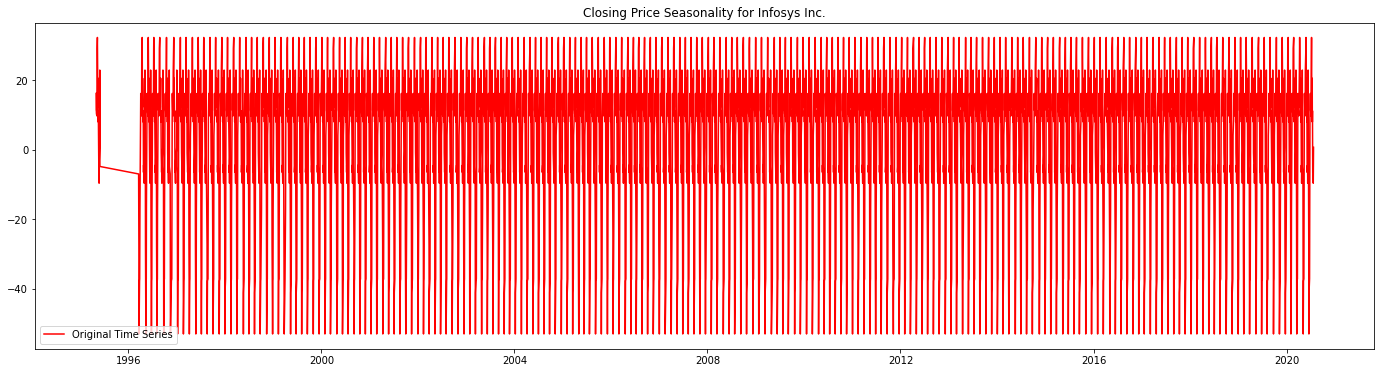

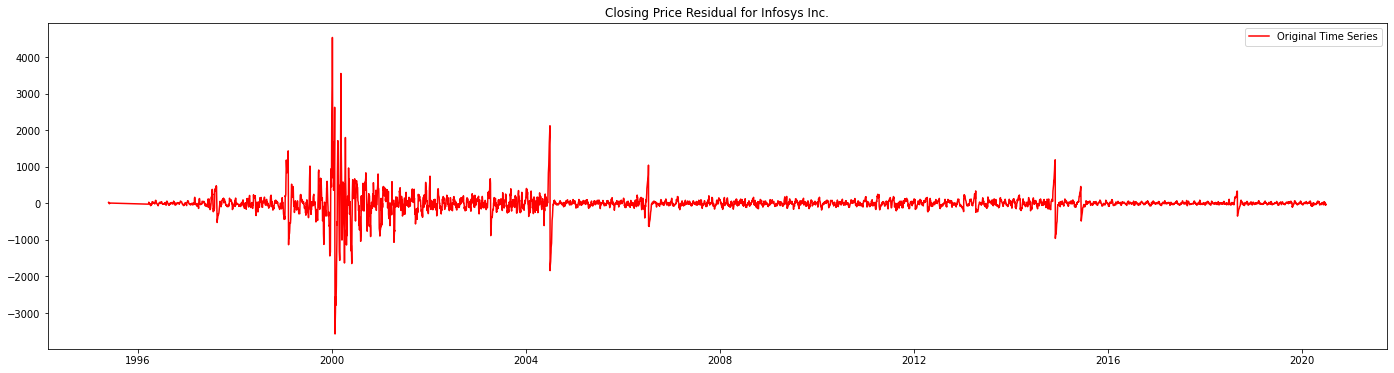

In [10]:
# Plot the Closing Price
plt.figure(figsize=(24,6))
plt.title('Closing Price Observed for Infosys Inc.')
plt.plot(result.observed, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()
# Plot the Closing Price Trend
plt.figure(figsize=(24,6))
plt.title('Closing Price Trend for Infosys Inc.')
plt.plot(result.trend, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()
# Plot the Closing Price Seasonality
plt.figure(figsize=(24,6))
plt.title('Closing Price Seasonality for Infosys Inc.')
plt.plot(result.seasonal, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()
# Plot the Closing Price Residual
plt.figure(figsize=(24,6))
plt.title('Closing Price Residual for Infosys Inc.')
plt.plot(result.resid, color='red',label='Original Time Series')
plt.legend(loc='best')
plt.show()

## Checking for Stationarity

For ARIMA (Auto-Regressive Integrated Moving Average) analysis, the time series has to be made stationary for further analysis. For a time series to be stationary, its statistical properties(mean, variance, etc) will be the same throughout the series, irrespective of the time at which you observe them. A stationary time series will have no long-term predictable patterns such as trends or seasonality. Time plots will show the series to roughly have a horizontal trend with the constant variance.

### Rolling Statistics (Moving Window "Averages")

We can plot the rolling mean and standard deviation to check if the statistics show an upward or downward trend. If these statistics vary over time, then the time series is highly likely to be non-stationary.
ADF and KPSS Test

To check the stationarity of the time series, we will also use the ADF (Augmented Dickey-Fuller) test and KPSS (Kwiatkowski–Phillips–Schmidt–Shintests) test. The null hypothesis of the ADF test is that the time series is not stationary whereas that for the KPSS is that it is stationary.

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -2.356967
p-value: 0.154252
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 4.181507
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/opt/conda/envs/python/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


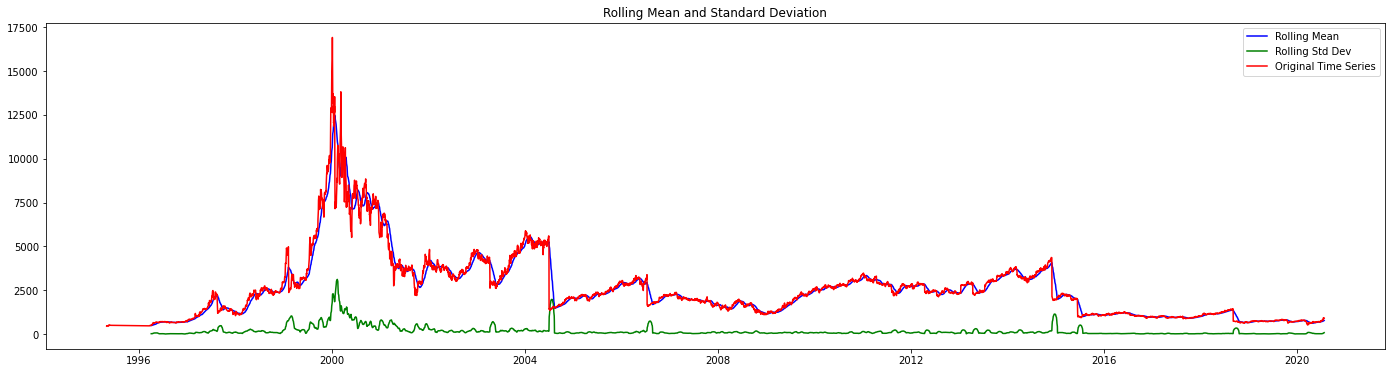

In [11]:
#Testing for stationarity using ADF and KPSS Tests.

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='red',label='Original Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
#    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    kpss_test = kpss(stock_close_price, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(Stock_data['Close'])

We can see the rolling mean trending up and down over time as the price of the stock increases and decreases respectively. The `p-value` of the ADF test turns out to be greater than `0.05` which means we cannot reject the null hypothesis at a significance level of 95%, in this case the series appears non-stationary. 

The p-value of the KPSS test is below 0.05 which means we can reject the null hypothesis at a significance level of 95%, in this case the series appears non-stationary. 

Both these tests suggest that the time series is not stationary, so we need to de-trend the series.

### How to de-trend the time series?

#### Differencing (Lag 1 Auto-Regressive) : 
A new series is constructed by calculating the value at the current time by differencing the value of actual observation of current time and its previous time.

    value(t) = actual_observation(t) - actual_observation(t-1)

#### Transformation (Mapping to different scale): 
Transforming the values using power, square root, log, etc can help to linearize the data. For example, taking a log of the values can help in obtaining a linear trend to the series with an exponential trend. log(exp(x))=x

#### Seasonal Differencing (Lag N Auto-Regressive): 
The values of the time series are calculated by differencing between one observation and its previous Nth observation. This can help in removing the trend

    value(t) = actual_observation(t) - actual_observation(t-N)

#### Fitting a model: 
We can fit a linear regression model to the time series. It will fit a linear trend on the time series. The values for the de-trended time series can be calculated by subtracting the actual observations with the values predicted by the model.  

    value(t) = actual_observation(t) - predicted(t)

The three methods above are themselves particular models, so all De-Trending uses some kind of model fitting.

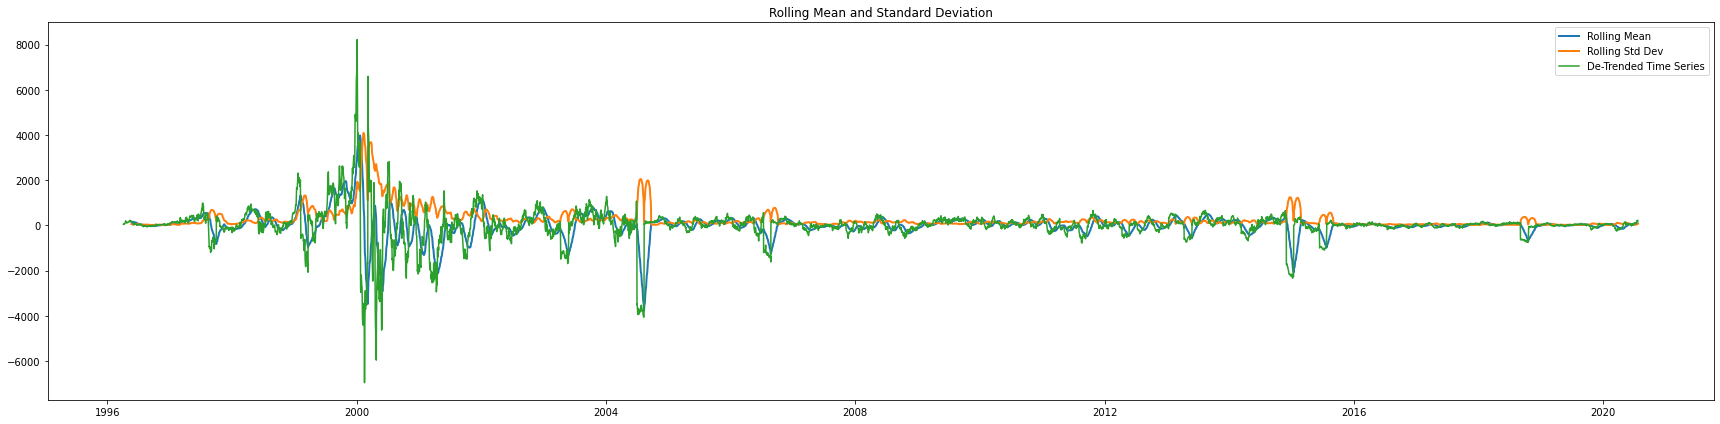

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -8.604439
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.119724
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/opt/conda/envs/python/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


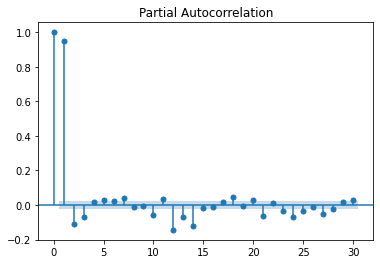

In [12]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
tau = 30 # Lag N value
Stock_data['Close_Detrend'] = (Stock_data['Close'] - Stock_data['Close'].shift(tau))

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(tau).mean()
    rolling_std_dev = stock_close_price.rolling(tau).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    plt.show()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(Stock_data['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(Stock_data['Close_Detrend'].dropna(), lags=tau)

After de-trending the time series, ADF and KPSS tests indicate that the time-series is stationary. The Partial AutoCorrelation Function (PACF) Plot suggests that correlation exists at certain lags; Lags 0 (of course self-correlation),1,2,3,12,13,14 are evident, suggesting same week price influence, and prior week price influence.

### Model Building

To forecast the prices, we can use smoothing methods and ARIMA methods. Smoothing methods can be used for non-stationary data whereas ARIMA requires the time series to be stationary. We can also make use of auto_arima, which makes the series stationary and determines the optimal order for the ARIMA model.

For each of the methods, we will perform multiple fits for the optimization of the hyperparameters and use the optimal values for the final model.  First we will split the dataset into two partitions.  One for model training and one for performance testing.

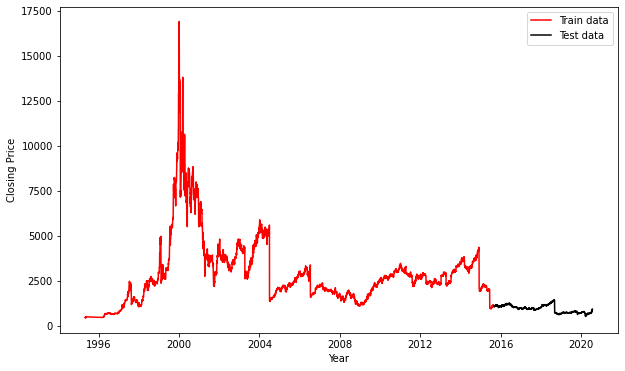

In [13]:
#split data into train and training set
Stock_data_arima = Stock_data['Close']
train_test_split_ratio = int(len(Stock_data_arima)*0.8)
train_data, test_data = Stock_data_arima[:train_test_split_ratio], Stock_data_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend(loc='best')
plt.show()

#### Simple Exponential Smoothing

Simple Exponential Smoothing or SES is used when the data does not contain any trend or seasonality. Smoothing Factor for level ($\alpha$) provides weightage to the influence of the observations. Larger values of $\alpha$ mean that more attention is given to the most recent past observation whereas smaller values indicate that more past observations are being considered for forecasting.

\begin{equation}
F_{t+1} = \alpha d_t + (1-\alpha)F_t
\end{equation}


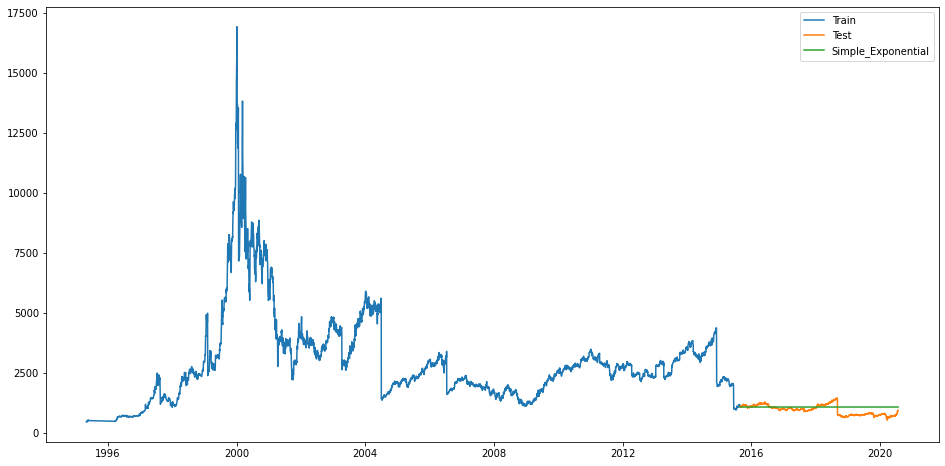

Simple Exponential Smoothing RMS :- 234.126 & Smoothing Level :- 1.0


In [14]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

Simple_Exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
  fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
  pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
  Simple_Exponential_df = Simple_Exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = Simple_Exponential_df.loc[Simple_Exponential_df['RMS'] == min(Simple_Exponential_df['RMS']),['Smoothing Level']].values


# Using optimised values from the lists.
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

#### Holt’s Exponential Smoothing

Holt’s Exponential Smoothing takes the trend into account for forecasting the time series. It is used when there is a trend in the data and no seasonality. It calculates the Smoothing value (the first equation), which is the same used in SES for forecasting. Trend Coefficient ($\beta$) provides weightage to the difference in the consequent smoothing values and the previous trend estimate. The forecasting is a combination of the smoothing value and the trend estimate.

\begin{equation}
S_t = \alpha d_t + (1-\alpha)F_t \\
b_t = \beta(S_t - S_{t-1}) + (1-\beta)b_{t-1} \\
F_{t+1} = S_t + b_t \\
\end{equation}

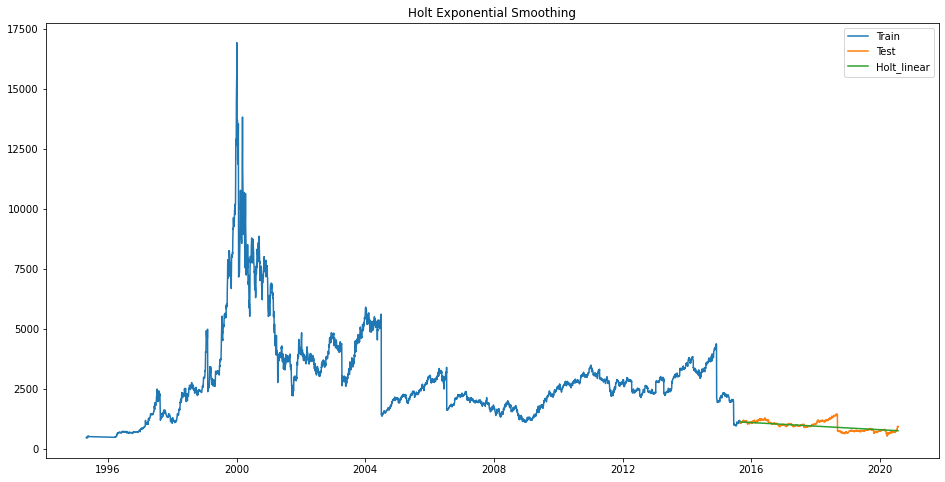

Holt’s Exponential Smoothing RMS :- 149.9 & Smoothing Level :- 0.2 & Smoothing Slope :- 0.05


In [15]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
  pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
  holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

#### Holt-Winters Exponential Smoothing

Holt-Winters Exponential Smoothing takes trend as well as seasonality into account for forecasting the time series. It forecasts the values using equations for calculating the level component, trend component, and the seasonal component in the time series. According to the seasonal variations in the data, either additive or the multiplicative version is used.

    insert latex here
Additive Method (Source: otexts)

    insert latex here
Multiplicative Method (Source: otexts)

#### Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA model is a combination of Auto-Regressive model and Moving Average model along with the Integration of differencing. Auto-Regressive model determines the relationship between an observation and a certain number of lagged observations. The Integrated part is the differencing of the actual observations to make the time series stationary. Moving Average determines the relationship between an observation and residual error obtained by using a moving average model on the lagged observations.

Auto-Regressive (p) -> Number of lag observations in the model. Also called as the lag order.

Integrated (d) -> The number of times the actual observations are differenced for stationarity. Also called as the degree of differencing.

Moving Average (q) -> Size of the moving average window. Also called as the order of moving average.

In [ ]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=64028.729, BIC=64054.666, Time=1.372 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=64035.210, BIC=64048.178, Time=0.098 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=64031.326, BIC=64050.778, Time=0.203 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=64032.090, BIC=64051.542, Time=0.266 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=64033.212, BIC=64039.697, Time=0.052 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=64034.837, BIC=64067.258, Time=0.813 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=63997.555, BIC=64029.977, Time=1.036 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=64002.081, BIC=64028.018, Time=0.519 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=63996.866, BIC=64035.772, Time=1.649 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=63958.678, BIC=64004.068, Time=3.037 seconds
Fit ARIMA(3,1,1)

In [218]:
# Fitting the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

In [218]:
# Forecasting the values.
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

In [218]:
#Plotting the predicted stock price and original price.
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [218]:
# Evaluating the model by calculating RMSE.
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

NameError: name 'auto_arima' is not defined

In [1]:
holt_linear_df.head()

NameError: name 'holt_linear_df' is not defined